## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Input

In [ ]:
# !gdown --id 1PEdKvi9U_LmrExfYyNvQnMwNNiZH3Xy5


In [ ]:
input_df = pd.read_excel('/content/demo (poultry manure).xlsx')
input_df

,852.78_nm,853.34_nm,853.9_nm,854.47_nm,855.03_nm,855.6_nm,856.16_nm,856.73_nm,857.29_nm,857.86_nm,...,2459.63_nm,2464.31_nm,2469_nm,2473.72_nm,2478.45_nm,2483.19_nm,2487.96_nm,2492.74_nm,2497.55_nm,2502.37_nm
0,"0,821418","0,818760","0,816091","0,814692","0,810726","0,809478","0,810052","0,807721","0,806011","0,806109",...,"1,255254","1,258521","1,261717","1,264543","1,266986","1,268774","1,269701","1,270082","1,270253","1,270040"


## Preprocessing

In [ ]:
def preprocessing(input_df):
  input_df = input_df.apply(lambda x: x.str.replace(',', '.', regex=True)) # thay thế dấy phẩy bởi dấu chấm
  spectra = input_df.astype('float64') # chuyển đổi sang float
  spectra = spectra.iloc[:,0:1002] # chỉ lấy giá trị tại 1002 bước sóng
  return spectra

In [ ]:
spectra = preprocessing(input_df) #Tiền xử lí dữ liệu từ file input

## Models

### Hàm trực quan dữ liệu

In [ ]:
id_to_class = {
  '0': 'Cattle manure',
  '1': 'Compost',
  '2': 'Other',
  '3': 'Pig manure',
  '4': 'Poultry droppings',
  '5': 'Poultry manure'
}

**Hàm vẽ đồ thị phổ NIR**

In [ ]:
def plot_spectra(spectra):
  wavelengths = pd.DataFrame(spectra.columns).apply(lambda x: x.str.replace('_nm', '', regex=True)).values.astype(float) #Lấy giá trị các bước sóng
  spectra = spectra.values
  plt.figure(figsize=(6, 3))
  plt.plot(wavelengths,spectra.reshape(-1,1))
  plt.xlabel('Wavelength')
  plt.ylabel('Absorbance')
  plt.show()

**Hàm vẽ đồ thị scores**

In [ ]:
def plot_scores(scores):
  plt.bar(list(id_to_class.values()), scores.flatten().tolist(), color ='maroon', width = 0.4)
  plt.xticks(fontsize=6)
  plt.xlabel("Scores")
  plt.ylabel("Probabilities")
  plt.show()

### MLP

In [ ]:
def MLP():
  model = Sequential([
    layers.Dense(512, activation='relu', input_dim=1002),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6 , activation='softmax')
  ])
  return model
model_MLP = MLP()
model_MLP.load_weights('MLP.h5')

In [ ]:
def MLP_predict(model,input):
  scores = model.predict(input)
  # plot_scores(scores)
  id = np.argmax(scores)
  return id_to_class[str(id)]


### CNN

**Hàm chuyển đổi chuỗi phổ NIR sang pseudo image: dùng chung cho cả CNN và Resnet**

In [ ]:
def convert_to_pseudo_image(Spectra_data):
  Spectra_data = tf.convert_to_tensor(Spectra_data)
  Spectra_data= tf.expand_dims(Spectra_data,axis=2)
  Spectra_data = tf.expand_dims(Spectra_data,axis=3)
  Spectra_data = tf.reshape(Spectra_data[:,0:968],(Spectra_data.shape[0],22,22,2))
  return Spectra_data

In [ ]:
def CNN():
  inputs = Input(shape=(22, 22, 2))
  x = layers.Conv2D(kernel_size=3, filters=16, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=32, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=64, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model
model_CNN = CNN()
model_CNN.load_weights('CNN.h5')

In [ ]:
def CNN_predict(model,input):
  input_pseudo_image = convert_to_pseudo_image(input)
  scores = model.predict(input_pseudo_image)
  # plot_scores(scores)
  id = np.argmax(scores)
  return id_to_class[str(id)]

### Resnet

In [ ]:
def residual_block(x, filters):

  x1 = layers.Conv2D(kernel_size=1, filters=filters, padding="same")(x)
  x1 = layers.BatchNormalization()(x1)

  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x2)
  x2 = layers.BatchNormalization()(x2)

  out = layers.Concatenate()([x1, x2])
  out = layers.ReLU()(out)

  return out

def ResNet():

  inputs = Input(shape=(22, 22, 2))
  x = residual_block(inputs,16)
  x = residual_block(x,32)
  x = residual_block(x,64)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model

model_Resnet = ResNet()
model_Resnet.load_weights('Resnet.h5')

In [ ]:
def Resnet_predict(model,input):
  input_pseudo_image = convert_to_pseudo_image(input)
  scores = model.predict(input_pseudo_image)
  # plot_scores(scores)
  id = np.argmax(scores)
  return id_to_class[str(id)]

### NIRsViT

In [ ]:
def PatchEmbedding(x):
  B, H, W, C = x.shape
  x = layers.Conv2D(64, kernel_size=8, strides=1)(x)
  x = tf.reshape(x, [-1, 16, 64])
  return x

def VisionTransformer():
  inputs = Input(shape=(22, 22, 2))
  x = inputs
  B, H, W , C = x.shape

  x1 = x[:, :H // 2, :W // 2,:]
  x2 = x[:, H // 2:, :W // 2,:]
  x3 = x[:, :H // 2, W // 2:,:]
  x4 = x[:, H // 2:, W // 2:,:]

  x1 = PatchEmbedding(x1)
  x2 = PatchEmbedding(x2)
  x3 = PatchEmbedding(x3)
  x4 = PatchEmbedding(x4)

  x = tf.concat([x1, x2, x3, x4], axis=1)

  x_skip = x
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x,x,x,x)
  x = tf.add(x_skip,x)
  x_skip = x
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = tf.add(x_skip,x)

  x = tf.reduce_mean(x, axis=1)
  x = layers.Dense(6 , activation='softmax')(x)
  model = Model(inputs=inputs, outputs=x)
  return model

model_NIRsViT = VisionTransformer()
model_NIRsViT.load_weights('NIRsViT.h5')

In [ ]:
def NIRsViT_predict(model,input):
  input_pseudo_image = convert_to_pseudo_image(input)
  scores = model.predict(input_pseudo_image)
  # plot_scores(scores)
  id = np.argmax(scores)
  return id_to_class[str(id)]

### NIRsViT + Upsample

In [ ]:
model_NIRsViT_Upsample = VisionTransformer()
model_NIRsViT_Upsample.load_weights('NIRsViT_Upsample.h5')

### NIRsViT + Focal Loss

In [ ]:
model_NIRsViT_FocalLoss = VisionTransformer()
model_NIRsViT_FocalLoss.load_weights('NIRsViT_FocalLoss.h5')

**Note: Hàm predict của 3 model CNN,Resnet,NIRsViT giống nhau, nhưng mình vẫn tách ra để không gây nhầm lẫn**

## Output

**Vẽ đồ thị phổ NIR**

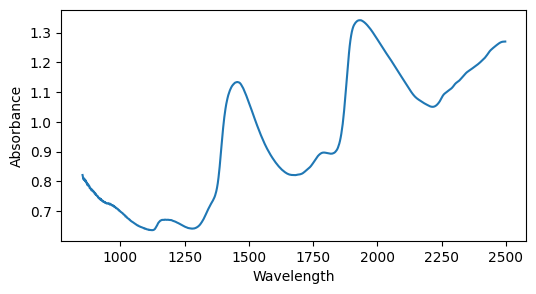

In [ ]:
plot_spectra(spectra)

**Output sử dụng mô hình MLP**

In [ ]:
print("Kết quả phân loại phân bón: ", MLP_predict(model_MLP,spectra))

1/1 [==============================] - 0s 130ms/step
Kết quả phân loại phân bón:  Cattle manure


**Output sử dụng mô hình CNN**

In [ ]:
print("Kết quả phân loại phân bón: ", CNN_predict(model_CNN,spectra))

1/1 [==============================] - 0s 172ms/step
Kết quả phân loại phân bón:  Cattle manure


**Output sử dụng mô hình Resnet**

In [ ]:
print("Kết quả phân loại phân bón: ", Resnet_predict(model_Resnet,spectra))

1/1 [==============================] - 0s 371ms/step
Kết quả phân loại phân bón:  Cattle manure


**Output sử dụng mô hình NIRsViT**

In [ ]:
print("Kết quả phân loại phân bón: ", NIRsViT_predict(model_NIRsViT,spectra))

1/1 [==============================] - 0s 365ms/step
Kết quả phân loại phân bón:  Cattle manure


**Output sử dụng mô hình NIRsViT + Upsample**

In [ ]:
print("Kết quả phân loại phân bón: ", NIRsViT_predict(model_NIRsViT_Upsample,spectra))

1/1 [==============================] - 0s 318ms/step
Kết quả phân loại phân bón:  Cattle manure


**Output sử dụng mô hình NIRsViT + Focal Loss**

In [ ]:
print("Kết quả phân loại phân bón: ", NIRsViT_predict(model_NIRsViT_FocalLoss,spectra))

1/1 [==============================] - 0s 300ms/step
Kết quả phân loại phân bón:  Pig manure
